# Notebook 5: Bias in Algorithmic Risk Scores for Health



This lab is based off of [Dissecting racial bias in an algorithm used to manage the health of populations](https://science.sciencemag.org/content/366/6464/447) by Ziad Obermeyer et al (2019).

# Table of Contents 

1. [What is Algorithmic Bias?](#0)<br>
2. [Medical Cost and Risk](#1)<br>
3. [Chronic Illness and Risk](#2)<br>
4. [Interactions Between Cost and Illness](#3)<br>
5. [Conclusions and Takeaways](#4)<br>
6. [An Improved Algorithm?](#5)<br>
7. [References](#6)<br>

### Dependencies

In [39]:
# Run this cell! 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import percentileofscore 
%matplotlib inline

import otter
generator = otter.Notebook()



---

## 1. What is Algorithmic Bias?<a id='0'></a>

The term 'bias,"has a number of meanings that depend upon the context in which it is used. When we describe a person or a situation to be biased, we usually mean that that person or situation favors one thing, person or group over another. Frequently, this favor or prejudice is deemed unfair, thus bias in common parlance can take on a negative weight. In statistics, bias (of an estimator) is defined as "the difference between this estimator's expected value and the true value of the parameter being estimated." Recently, people have identified bias in algorithmic models. **Algorithmic bias** refers to algorithmic models that systematically and unfairly discriminate against certain individuals or groups in favor of others. The concept of "algorithmic bias" is provocative because people tend to think of algorithmic systems as "neutral" and "objective." Researchers have discovered biases in algorithmic models that [produce search engine results](https://www.technologyreview.com/2018/02/26/3299/meet-the-woman-who-searches-out-search-engines-bias-against-women-and-minorities/), [underpin social media platforms](https://www.bbc.com/news/technology-53498685), [screen resumes](https://www.reuters.com/article/us-amazon-com-jobs-automation-insight/amazon-scraps-secret-ai-recruiting-tool-that-showed-bias-against-women-idUSKCN1MK08G), determine mortgages, and [support health care decisions](https://www.nytimes.com/2020/08/25/sports/football/nfl-concussion-racial-bias.html).

From [*Bias in Computer Systems* by Friedman and Nissenbaum](https://nissenbaum.tech.cornell.edu/papers/biasincomputers.pdf), bias arises in three primary ways in computer systems: 
- **Preexisting bias** arises when computer systems embody biases that exist independently of the system and usually prior to its creation, then perpetuates the preexisting bias. It can creep into a system through conscious and explicit efforts of individuals or institutions, or unconsciously despite good intentions.
- **Technical bias** arises from system constraints or technical considerations, such as hardware limitation, random number generation, or even making human constructs usable by a computer (quantifying qualitative data for example).
- **Emergent bias** emerges in the context of use after the system has been designed. 

--- 

## Background

To effectively manage patients, health systems often need to estimate particular patients' health risks, or the likelihood that a patient will develop certain types of medical conditions in the future. Quantitative measures, or "risk scores," can help health care providers to prioritize patients for certain kinds of treatments and preventive interventions, helping them to allocate resources to patients who need them.

In this lab, we examine an algorithm widely-used in the health care industry to establish quantitative risk scores for patients. This serves as a screening tool to alert primary care doctors to high-risk patients. This algorithm uses medical cost (i.e., the amount that a patient's medical treatments cost) as a proxy for health. Through analysis of the data used in the model, we will discover how this algorithm embeds a bias against Black patients, undervaluing their medical risk relative to White patients: given the same risk score, Black patients are sicker than White patients. Crucially, this bias is not immediately visible when comparing medical costs across White and Black patients.

We'll follow similar steps taken in the paper to uncover bias in this particular health risk algorithm by decomposing the variables in relation to the calculated risk scores. The key insight of Obermeyer et al's work is that bias frequently slips into algorithmic systems unnoticed, particularly when sensitive characteristics (such as race) are omitted or backgrounded in the data science process. Bias in algorithms affects people's lives very concretely: it makes it more difficult for Black patients to receive the care they need.

-----
## 2. Medical Cost and Risk <a id='1'></a>

To help hospitals and insurance companies identify patients who should qualify for “high-risk care management” programs, the algorithm assigns each patient a risk score from 0 to 100. It predicts a patient’s total medical expenditure based on data from insurance claims (age, sex, diagnosis codes, etc.) and uses this variable as a proxy for health care needs.  Patient risk scores are then generated as functions of their predicted expenditures. For example, a patient with a calculated risk score of 80 has a predicted cost of 126,600 and a patient with a calculated risk score of .4 has a predicted cost of 500.

If the model is calibrated (adjusted so the predictions match the empirical data) across race in terms of risk score and expenditure, Black and White patients with a given risk score should have similar total medical expenditures, on average.

To see if this is true, we will generate a graph that shows the mean total medical expenditure by race given a risk score percentile.

The first step is to load the data the model uses.

In [16]:
data = pd.read_csv('health-care-bias-lab.csv')
data.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


Next, we add a column of risk percentiles to the data frame named `risk_percentile`. We create the column using the `convert_to_percentile` utility function. This function takes in a data frame and column name that we want to convert, then transformed the data in the specified column into percentiles. The transformed percentile data is then added as a new column to our data.

The *risk percentile* of an individual is the value below which a percentage of the data (risk score) falls. This risk score is assigned by the algorithm to an individual.

In [40]:
# convert risk scores to perentiles
risk_score_t = data['risk_score_t'] 
risk_percentile = risk_score_t.apply(lambda x: percentileofscore(risk_score_t, x))

# add a new column "risk_percentile"
data["risk_percentile"] = risk_percentile

data.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t,risk_percentile,illness_percentile
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,35.462447,22.765661
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,0,1,0,0,1,4,3,86.026156,84.993031
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,3.571868,22.765661
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,11.230116,22.765661
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,1,1,97.589374,56.957199


Now we create a data frame called `group_cost` with the average total medical expenditure for each race at each risk percentile. We do this by grouping the data by risk percentile and race, then taking the mean of `cost_t` for each group, which contains the average total cost associated with the specific risk percentage and race combination. 

In [41]:
# grouping by "risk_percentile" and "race"
group_cost = data.groupby(["risk_percentile", "race"])

# taking the mean of each respective group in the data
group_cost = group_cost[["cost_t"]].mean().reset_index()
group_cost.head()

,risk_percentile,race,cost_t
0,0.210110,black,819.230769
1,0.210110,white,769.101124
2,0.487865,black,588.888889
3,0.487865,white,1660.344828
4,0.559610,white,866.666667


We divide the `group_cost` data frame into two data frames based on race.

In [42]:
b_cost = group_cost[group_cost['race'] == 'black']
w_cost = group_cost[group_cost['race'] == 'white']

A scatter plot is made to display the risk percentile against the medical cost which is categorized by race; specifically by Black and White patients. 

**Aside:** Why should we scatter our data points in this situation rather than use line plots seen in notebooks 1 and 2? 

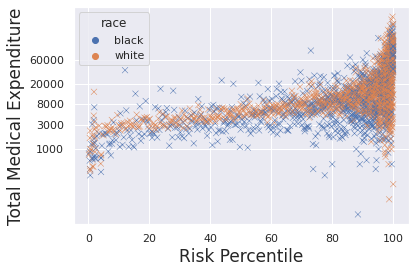

In [43]:
ax = sns.scatterplot(x = "risk_percentile", y = "cost_t", data = group_cost, hue = "race", marker = "x", legend = "full")
plt.yscale('log')
ax.set_yticks([1000, 3000, 8000, 20000, 60000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.legend;
sns.set(rc={'figure.figsize':(9,7)})
plt.xlabel('Risk Percentile', size = 17)
plt.ylabel('Total Medical Expenditure', size = 17);

In the scatter plot above, the x's that represent Black and White patients are very interspersed, which makes it difficult to see any relationships present between the two groups. To fix this, we fit a LOWESS (Locally Weighted Scatterplot Smoothing) model to the data for each race. LOWESS models are used to create smooth lines through scatter plot data that help highlight relationships between variables and trends that might be present. The lines are created by computing the average data point using neighboring data points for each point on the x-axis. In this case, the LOWESS model calculated the average total medical expenditure for each risk percentile in black and white patients. 

The specifics of how LOWESS models are created is out of the scope of this notebook, but if you're interested in knowing more, you can read  about LOWESS models [here](https://blogs.sas.com/content/iml/2016/10/17/what-is-loess-regression.html#:~:text=Loess%20regression%20is%20a%20nonparametric,model%20with%20a%20parametric%20curve).

In [44]:
risk_percentile_array_b = np.array(b_cost['risk_percentile'])
risk_percentile_array_w = np.array(w_cost['risk_percentile'])
b_cost_array = np.array(b_cost['cost_t'])
w_cost_array = np.array(w_cost['cost_t'])
b_cost_lowess = lowess(b_cost_array, risk_percentile_array_b, it=35, frac=0.2, delta=2)
w_cost_lowess = lowess(w_cost_array, risk_percentile_array_w, it=35, frac=0.2, delta=2)

In the following cell, we plot a curve fitted by the LOWESS model along with the data points in the plot from before, which results in the orange and blue lines through the graph. The orange and blue lines display the overall relationship of total medical expenditure and risk percentile in White and Black patients respectively. 

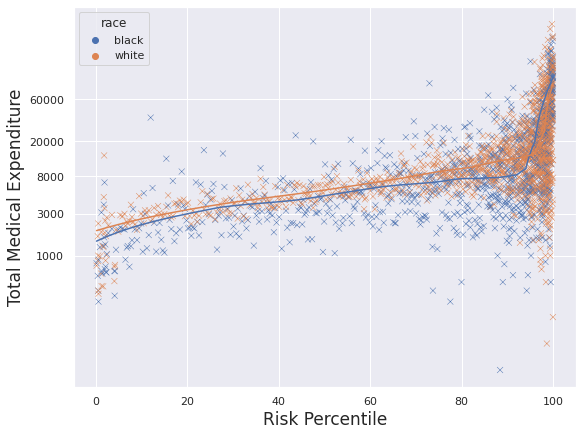

In [45]:
ax = sns.scatterplot(x = "risk_percentile", y = "cost_t", data = group_cost, hue = "race", marker = "x", legend = "full")
plt.yscale('log')
plt.plot(risk_percentile_array_b, b_cost_lowess[:, 1])
plt.plot(risk_percentile_array_w, w_cost_lowess[:, 1])
ax.set_yticks([1000, 3000, 8000, 20000, 60000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel('Risk Percentile', size = 17)
plt.ylabel('Total Medical Expenditure', size = 17);

<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 2.1:</b> What do you notice about the relationship between medical expenditure and risk score by race? Can you conclude from this data that the model is biased?
</div>

<!--
BEGIN QUESTION
name: q21
points: 1
manual: true
-->

**Answer:** *Your Answer Here*

<!-- END QUESTION -->

----

## 3. Chronic Illness and Risk <a id='2'></a>

Next, we will check to see if the model is calibrated across groups in terms of risk score and chronic illness. In other words, we will check to see whether Black and White patients have the same level of health for a given risk score.

If cost is a good proxy for need, we would expect the shape of the curves for the two groups to be close to each other as it was in the prior graph.  In other words, health care cost conditional on health should not vary between groups.

Similar to the previous process, we begin by creating a data frame with the average number of chronic illnesses for each race at each risk percentile. 


In [46]:
grouped_by_race = data.groupby(["risk_percentile", "race"])[["gagne_sum_t"]].mean().reset_index()
grouped_by_race.head()

,risk_percentile,race,gagne_sum_t
0,0.210110,black,0.038462
1,0.210110,white,0.028090
2,0.487865,black,0.000000
3,0.487865,white,0.034483
4,0.559610,white,0.000000


Next, we divide the grouped dataframe into two dataframes based on race.

In [47]:
black_patients = grouped_by_race[grouped_by_race['race'] == 'black']
white_patients = grouped_by_race[grouped_by_race['race'] == 'white']

We then create a scatterplot of risk percentile against the average number of chronic ilnesses and categorize by race.


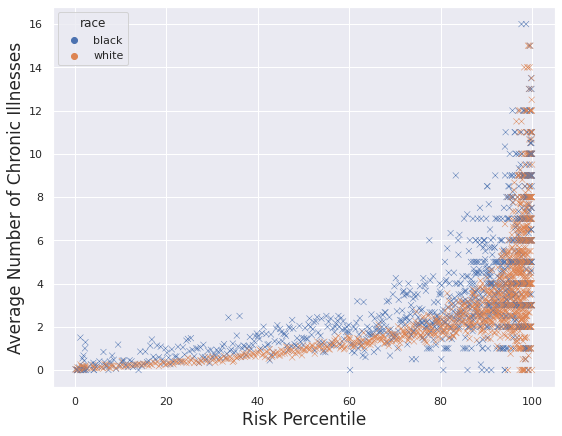

In [48]:
ax = sns.scatterplot(x="risk_percentile", y="gagne_sum_t", data=grouped_by_race, hue="race", marker="x", legend="full");
plt.xlabel('Risk Percentile', size = 17)
plt.ylabel('Average Number of Chronic Illnesses', size = 17);

Compared to the plot in the previous section, the trends of the scatter plot above are a bit more obvious. In this example, we fit a Generalized Linear Model (GLM) to the data for each race. Again, the specifics of how GLMs work is out of the scope of this notebook, but you can feel free to read more about GLMs [here](https://towardsdatascience.com/generalized-linear-models-9ec4dfe3dc3f). What's important for us to know about GLMs is that, similar to the LOWESS model, GLMs also create a smooth line through the data that helps to see trends in the data. This is beneficial because we want to identify any potential disparities between black and white patients. 

In [49]:
X_b = sm.add_constant(np.array(black_patients["risk_percentile"]))
model_b = sm.GLM(list(black_patients["gagne_sum_t"]), X_b, family=sm.families.Gaussian(sm.families.links.log()))
model_b_results = model_b.fit()

X_w = sm.add_constant(np.array(white_patients["risk_percentile"]))
model_w = sm.GLM(list(white_patients["gagne_sum_t"]), X_w, family=sm.families.Gaussian(sm.families.links.log()))
model_w_results = model_w.fit()

Finally we plot the GLM model on the scatter plot. The orange and blue lines display the overall relationship between the average number of chronic illnesses and risk percentile in white and black patients respectively. 

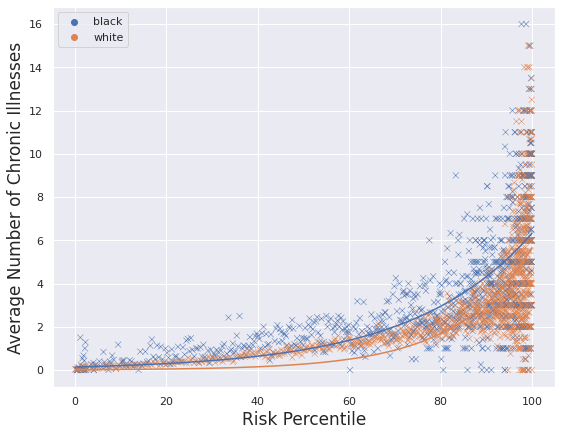

In [50]:
sns.scatterplot(x="risk_percentile", y="gagne_sum_t", data=grouped_by_race, hue="race", marker="x", legend="full")
plt.plot(np.array(black_patients["risk_percentile"]), model_b_results.predict())
plt.plot(np.array(white_patients["risk_percentile"]), model_w_results.predict())
plt.legend();
plt.xlabel('Risk Percentile', size = 17)
plt.ylabel('Average Number of Chronic Illnesses', size = 17);

<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 3.1:</b> What do you notice about the relationship between chronic illness and risk score by race? What, if anything, does the data analysis we have done tell us about whether the model is racially biased or not?
</div>

<!--
BEGIN QUESTION
name: q31
points: 1
manual: true
-->

**Answer:** *Your Answer Here*

<!-- END QUESTION -->

----
## 4. Interactions Between Cost and Illness <a id='3'></a>

Our work above shows us that a black patient and a white patient with the same risk score tend to spend the same amount on medical care on average, yet the Black patient tends to have more chronic illnesses.


<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 4.1:</b> Why might this be the case? What barriers, injustices, or systemic issues might black patients face or have faced that could be causing this disparity?
</div>

<!--
BEGIN QUESTION
name: q41
points: 1
manual: true
-->


**Answer:** *Your Answer Here*

<!-- END QUESTION -->

--- 
To understand this interaction, we will generate a graph that shows the mean total medical expenditure by race, given the number of chronic illnesses.

First, we add a column of illness percentiles to the data frame called `illness_percentile`. The illness percentile is found using the convert_to_percentile utility function defined above.

In [51]:
gagne_sum_t = data['gagne_sum_t']
illness_percentile = gagne_sum_t.apply(lambda x: percentileofscore(gagne_sum_t, x))
data['illness_percentile'] = illness_percentile
data.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t,risk_percentile,illness_percentile
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,35.462447,22.765661
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,0,1,0,0,1,4,3,86.026156,84.993031
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,3.571868,22.765661
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,11.230116,22.765661
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,1,1,97.589374,56.957199


Next, we create a data frame which has the average total medical expenditure for each race (black and white patients) at each illness percentile.

In [52]:
illnesses = data.groupby(["illness_percentile", "race"])[["cost_t"]].mean().reset_index()
illnesses.head()

,illness_percentile,race,cost_t
0,22.765661,black,3309.931507
1,22.765661,white,4372.520651
2,56.957199,black,5242.040185
3,56.957199,white,6440.395738
4,74.810389,black,7176.976744


We then divide the illnesses into two data frames based on race; specifically black and white patients.

In [53]:
illness_b = illnesses[illnesses['race'] == 'black']
illness_w = illnesses[illnesses['race'] == 'white']

Similar to the process in Section 1, we create a scatterplot of illness percentile against the medical cost and group by race, and then fit a LOWESS model to the scaterplot for each race.

In [54]:
illness_percentile_array_b = np.array(illness_b['illness_percentile'])
illness_percentile_array_w = np.array(illness_w['illness_percentile'])
illness_cost_b = np.array(illness_b['cost_t'])
illness_cost_w = np.array(illness_w['cost_t'])
b_illness_lowess = lowess(illness_cost_b, illness_percentile_array_b, it=35, frac=0.3, delta=2)
w_illness_lowess = lowess(illness_cost_w, illness_percentile_array_w, it=35, frac=0.3, delta=2)

Finally, we plot the LOWESS model on the scatterplot.

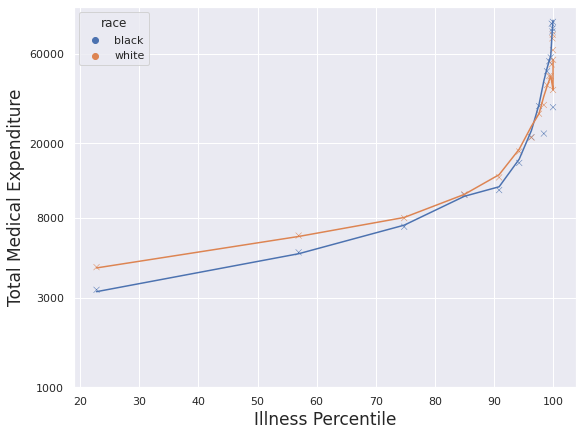

In [55]:
ax = sns.scatterplot(x = "illness_percentile", y = "cost_t", data = illnesses, hue = "race", marker = "x", legend = "full")
plt.yscale('log')
plt.plot(illness_percentile_array_b, b_illness_lowess[:, 1])
plt.plot(illness_percentile_array_w, w_illness_lowess[:, 1])
ax.set_yticks([1000, 3000, 8000, 20000, 60000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel('Illness Percentile', size = 17)
plt.ylabel('Total Medical Expenditure', size = 17);

<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 4.2:</b> What can you conclude about the relationship between cost and chronic illness? Why might this relationship exist? What are consequences for the risk score model?
</div>

<!--
BEGIN QUESTION
name: q42
points: 1
manual: true
-->

**Answer:** *Your Answer Here*

<!-- END QUESTION -->

---

## 5. Conclusions and Takeaways <a id='4'></a>

Even systems that appear balanced across racial groups at first glance may belie underlying biases in the datasets. Thus, seemingly unbiased predictors, such as cost, can in fact be highly correlated with a biasing variable such as race, gender, income or other relational characteristics.

In this example, bias emerged from using an indicator of need (cost) that was itself influenced by race. Biased estimation of need between races resulted.

To better understand the ways in which race influences health care cost, here is a segment from Obermeyer et al’s paper:
 
>The literature broadly suggests two main potential channels [through which racial discrepancies in healthcare cost are created]. **First, poor patients face substantial barriers to accessing health care, even when enrolled in insurance plans.** Although the population we study is entirely insured, there are many other mechanisms by which poverty can lead to disparities in use of health care: geography and differential access to transportation, competing demands from jobs or child care, or knowledge of reasons to seek care (1-3). To the extent that race and socioeconomic status are correlated, these factors will differentially affect Black patients. **Second, race could affect costs directly via several channels: direct (“taste-based”) discrimination, changes to the doctor–patient relationship, or others.** A recent trial randomly assigned Black patients to a Black or White primary care provider and found significantly higher uptake of recommended preventive care when the provider was Black (4). This is perhaps the most rigorous demonstration of this effect, and it fits with a larger literature on potential mechanisms by which race can affect health care directly. For example, it has long been documented that Black patients have reduced trust in the health care system (5), a fact that some studies trace to the revelations of the Tuskegee study and other adverse experiences (6). A substantial literature in psychology has documented physicians’ differential perceptions of Black patients, in terms of intelligence, affiliation (7), or pain tolerance (8). **Thus, whether it is communication, trust, or bias, something about the interactions of Black patients with the health care system itself leads to reduced use of health care. The collective effect of these many channels is to lower health spending substantially for Black patients, conditional on need—a finding that has been appreciated for at least two decades (9, emphasis added).**

----

## 6. An Improved Algorithm? <a id='5'></a>

Following up with the previous section, how could we use the data we have to create new proxies for health needs that may be less biased than medical costs? Obermeyer et al. suggested to keep the model infrastructure - the sample (data used), predictors (excluding race), training process, etc. - but changing the label. Instead of future cost, they created a variable that combined health prediction with cost prediction which resulted in an 84% reduction in bias. 

Though the labels of the data collected reflect structural inequalities, the results suggest that biases are "fixable" and call for changing the data we feed algorithms, specifically the labels. 

<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 6.1:</b> Suppose a less biased algorithm is made available to health care systems. To what extent is a technical fix (such as using less biased predictors) helpful? What kinds of changes need to be implemented in the health care system?
</div>

<!--
BEGIN QUESTION
name: q61
points: 1
manual: true
-->

**Answer:** *Your Answer here*

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->
<div class="alert alert-block alert-info">
<b>Question 6.2:</b> What are other applications of prediction algorithms where this type of bias may also arise?
</div>

<!--
BEGIN QUESTION
name: q62
points: 1
manual: true
-->

**Answer:** *Your Answer here*

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class="alert alert-block alert-info">
<b>Labor Question:</b> How much time did you spend completing this module? Did you find outside resources that helped you? if so what were they?
</div>


<!--
BEGIN QUESTION
name: QL
points: 1
manual: true
-->


**Answer:** *Your Answer here*

<!-- END QUESTION -->

#### Feedback Survey
Please consider filling out this [survey](https://docs.google.com/forms/d/e/1FAIpQLScd1q8VqvOMuVvLfhbVswckYKg1HFVwVu_bTF5NWbVZr4qWhw/viewform?usp=sf_link) to help us improve this module.

In [56]:
# Save your notebook first, then go to `Kernel` > `Restart and Run All Cells`
# Download the zip file, which contains a copy of your notebook and your written responses.
generator.export("notebook5S22.ipynb")

----

## 7. References <a id='6'></a>

Adapted from:
ML Failures lab: Dissecting Racial Bias by Nick Merrill, Inderpal Kaur, Samuel Greenberg is licensed under CC BY-NC-SA 4.0. To view a copy of this license, visit https://creativecommons.org/licenses/by-nc-sa/4.0

1. K. Fiscella, P. Franks, M. R. Gold, C. M. Clancy, JAMA 283, 2579–2584 (2000).
2. N. E. Adler, K. Newman, Health Aff. 21, 60–76 (2002).
3. N. E. Adler, W. T. Boyce, M. A. Chesney, S. Folkman, S. L. Syme, JAMA 269, 3140–3145 (1993).
4. M. Alsan, O. Garrick, G. C. Graziani, “Does diversity matter for health? Experimental evidence from Oakland” (National Bureau of Economic Research, 2018).
5. K. Armstrong, K. L. Ravenell, S. McMurphy, M. Putt, Am. J. Public Health 97, 1283–1289 (2007).
6. M. Alsan, M. Wanamaker, Q. J. Econ. 133, 407–455 (2018).
7. M. van Ryn, J. Burke, Soc. Sci. Med. 50, 813–828 (2000).
8. K. M. Hoffman, S. Trawalter, J. R. Axt, M. N. Oliver, Proc. Natl. Acad. Sci. U.S.A. 113, 4296–4301 (2016).
9. J. J. Escarce, F. W. Puffer, in Racial and Ethnic Differences in the Health of Older Americans (National Academies Press, 1997), chap. 6; www.ncbi.nlm.nih.gov/books/ NBK109841/.


--- 